In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/Data8/accidents_2022_CA.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

df_dask = dd.read_csv('/content/accidents_2022_CA.csv')
df = df_dask.compute()

Mounted at /content/drive


In [ ]:
df.shape

(277817, 29)

In [ ]:
df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Street,City,County,State,Zipcode,Airport_Code,...,Railway,Station,Stop,Traffic_Calming,Traffic_Signal,Weather_Condition_Clear,Weather_Condition_Cloudy,Weather_Condition_Drizzle,Weather_Condition_Snow,Weather_Condition_Windy
0,3,37.328312,-121.871811,0.0,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,False,False
1,2,38.321342,-122.713707,0.0,1,1,1,0,1,1,...,False,False,False,False,False,True,False,False,False,False
2,3,37.700714,-121.773895,0.0,2,2,2,0,2,2,...,False,False,False,False,True,True,False,False,False,False
3,2,37.395771,-122.012772,0.0,3,3,0,0,3,3,...,False,False,False,False,False,True,False,False,False,False
4,2,38.481682,-121.408768,0.0,4,4,3,0,4,4,...,False,False,False,False,False,True,False,False,False,False


<ipython-input-275-13296d94964f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Severity', y='Accidents', data=df_severity, palette='Reds')


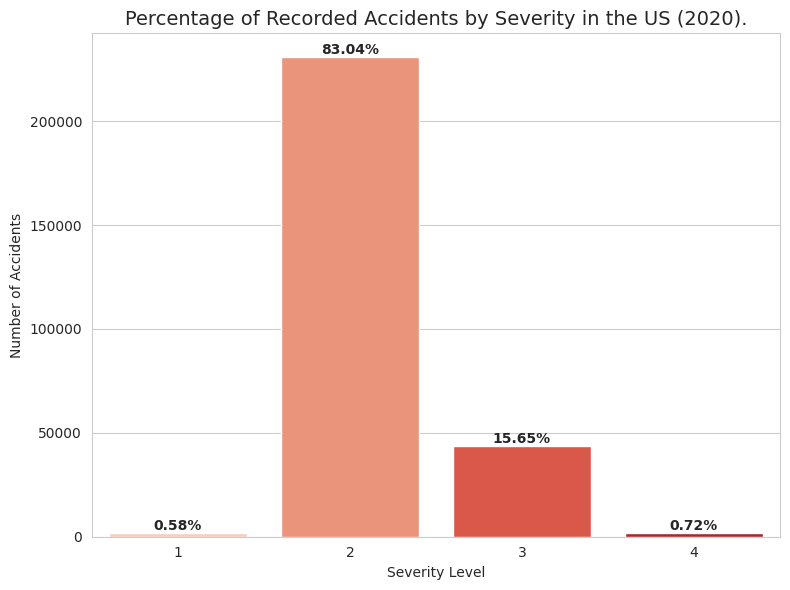

In [ ]:
# Compter les accidents par gravité
accidents_by_severity = df['Severity'].value_counts().sort_index()

# Calculer les pourcentages
total_accidents = len(df)
severity_percentages = (accidents_by_severity / total_accidents) * 100

# Créer un DataFrame pour l'affichage
df_severity = pd.DataFrame({
    'Severity': accidents_by_severity.index.astype(str),
    'Accidents': accidents_by_severity.values,
    'Percentage': severity_percentages.values
})

# Tracer le graphique
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
barplot = sns.barplot(x='Severity', y='Accidents', data=df_severity, palette='Blues_d')

# Ajouter les pourcentages au-dessus des barres
for i, row in df_severity.iterrows():
    barplot.text(i, row['Accidents'], f"{row['Percentage']:.2f}%", ha='center', va='bottom', fontsize=10, weight='bold')

plt.title('Percentage of Recorded Accidents by Severity in the US (2020).', fontsize=14)
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

In [3]:
# Stratified sampling to maintain severity distribution
df_sample = df.groupby('Severity', group_keys=False).apply(
    lambda x: x.sample(frac=0.2, random_state=42)
)

<ipython-input-3-4fe0e0e6148b>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('Severity', group_keys=False).apply(


In [4]:
from sklearn.model_selection import train_test_split

# Features and target
X = df_sample.drop('Severity', axis=1)
y = df_sample['Severity'] - 1  # KNN expects classes starting from 0 (0 to 3)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# K-Nearest Neighbors (KNN)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix


# KNN model (try different values of k: 3, 5, 7, etc.)
model_knn = KNeighborsClassifier(n_neighbors=5,
    weights='distance',
    metric='minkowski',
    p=2,                # Distance euclidienne
    algorithm='auto',
    leaf_size=30)
model_knn.fit(X_train, y_train)

# Predictions
y_pred_knn = model_knn.predict(X_test)



In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_enhanced_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Plot an enhanced confusion matrix with normalized view and performance metrics

    Args:
        y_true (array): True labels
        y_pred (array): Predicted labels
        model_name (str): Name of model for title
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ['1', '2', '3', '4']

    # Create figure
    plt.figure(figsize=(4, 5))

    # Plot absolute values
    plt.subplot(2, 1, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels,
                cbar=False)
    plt.title(f"{model_name} - Confusion Matrix (Counts)")
    plt.xlabel("Predicted Severity")
    plt.ylabel("Actual Severity")


    # Print classification metrics
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

    # Calculate class-wise accuracy
    class_acc = cm.diagonal()/cm.sum(axis=1)
    print("\nClass-wise Accuracy:")
    for i, acc in enumerate(class_acc):
        print(f"Severity {i+1}: {acc:.2%}")



Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        65
           2       0.88      0.92      0.90      9228
           3       0.47      0.38      0.42      1740
           4       0.23      0.04      0.06        80

    accuracy                           0.82     11113
   macro avg       0.39      0.33      0.35     11113
weighted avg       0.80      0.82      0.81     11113


Class-wise Accuracy:
Severity 1: 0.00%
Severity 2: 91.89%
Severity 3: 37.93%
Severity 4: 3.75%


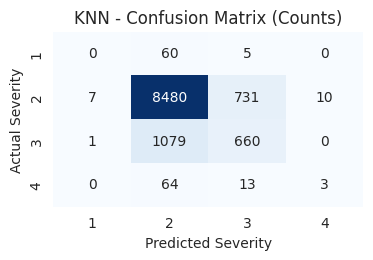

In [ ]:
plot_enhanced_confusion_matrix(y_test, y_pred_knn, model_name="KNN")

# Random forest


Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        65
           2       0.91      0.98      0.94      9228
           3       0.83      0.54      0.66      1740
           4       1.00      0.01      0.02        80

    accuracy                           0.90     11113
   macro avg       0.68      0.38      0.41     11113
weighted avg       0.89      0.90      0.88     11113


Class-wise Accuracy:
Severity 1: 0.00%
Severity 2: 97.94%
Severity 3: 54.25%
Severity 4: 1.25%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


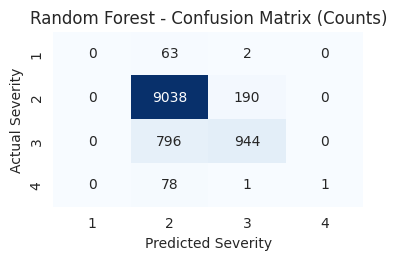

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Model
rf = RandomForestClassifier(min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    bootstrap=True,
    criterion='entropy')
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
plot_enhanced_confusion_matrix(y_test, y_pred_rf, model_name="Random Forest")


Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        97
           2       0.91      0.98      0.94     13843
           3       0.81      0.58      0.67      2609
           4       1.00      0.03      0.06       121

    accuracy                           0.90     16670
   macro avg       0.68      0.40      0.42     16670
weighted avg       0.89      0.90      0.89     16670


Class-wise Accuracy:
Severity 1: 0.00%
Severity 2: 97.54%
Severity 3: 57.61%
Severity 4: 3.31%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


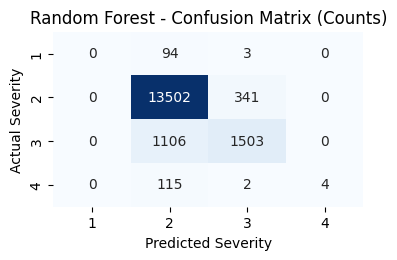

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


# Model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    min_samples_split=6,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)

rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

plot_enhanced_confusion_matrix(y_test, y_pred_rf, model_name="Random Forest")


Classification Report:
              precision    recall  f1-score   support

           1       0.22      0.14      0.17        64
           2       0.92      0.94      0.93      9250
           3       0.69      0.63      0.66      1724
           4       0.31      0.12      0.17        75

    accuracy                           0.88     11113
   macro avg       0.54      0.46      0.48     11113
weighted avg       0.88      0.88      0.88     11113


Class-wise Accuracy:
Severity 1: 14.06%
Severity 2: 94.31%
Severity 3: 63.17%
Severity 4: 12.00%


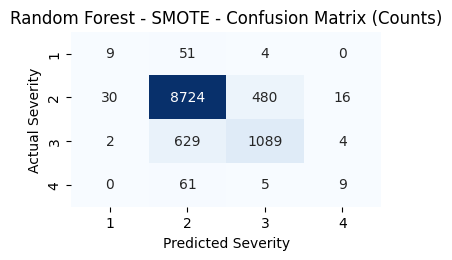

In [11]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train RandomForest with class weights
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    min_samples_split=6,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)
rf.fit(X_resampled, y_resampled)

# Predict on original test set
y_pred_rf = rf.predict(X_test)

plot_enhanced_confusion_matrix(y_test, y_pred_rf, model_name="Random Forest - SMOTE")


Classification Report:
              precision    recall  f1-score   support

           1       0.22      0.12      0.16        64
           2       0.92      0.94      0.93      9250
           3       0.69      0.64      0.66      1724
           4       0.29      0.09      0.14        75

    accuracy                           0.88     11113
   macro avg       0.53      0.45      0.47     11113
weighted avg       0.88      0.88      0.88     11113


Class-wise Accuracy:
Severity 1: 12.50%
Severity 2: 94.24%
Severity 3: 63.52%
Severity 4: 9.33%


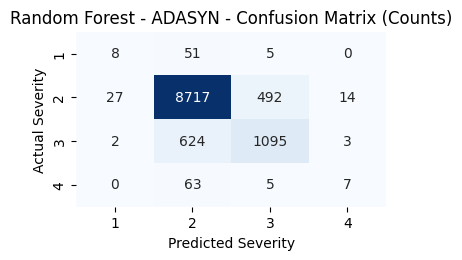

In [12]:
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Resample training data with ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Train Random Forest on resampled data
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    min_samples_split=6,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)
rf.fit(X_resampled, y_resampled)

# Predict on original test set
y_pred_rf = rf.predict(X_test)

# Evaluate
plot_enhanced_confusion_matrix(y_test, y_pred_rf, model_name="Random Forest - ADASYN")


# xgboost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:26:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

           1       0.20      0.02      0.03        65
           2       0.92      0.97      0.94      9228
           3       0.78      0.61      0.68      1740
           4       0.50      0.06      0.11        80

    accuracy                           0.90     11113
   macro avg       0.60      0.41      0.44     11113
weighted avg       0.89      0.90      0.89     11113


Class-wise Accuracy:
Severity 1: 1.54%
Severity 2: 96.78%
Severity 3: 60.80%
Severity 4: 6.25%


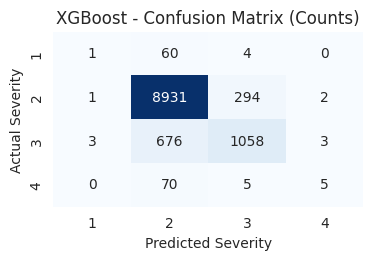

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create XGBoost model
xgb = XGBClassifier(
    objective='multi:softmax',   # for multi-class classification
    eval_metric='mlogloss',
    num_class=4,
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)
plot_enhanced_confusion_matrix(y_test, y_pred_xgb, model_name="XGBoost")


Classification Report:
              precision    recall  f1-score   support

           1       0.43      0.05      0.08        64
           2       0.92      0.97      0.94      9250
           3       0.77      0.61      0.68      1724
           4       0.80      0.05      0.10        75

    accuracy                           0.90     11113
   macro avg       0.73      0.42      0.45     11113
weighted avg       0.89      0.90      0.89     11113


Class-wise Accuracy:
Severity 1: 4.69%
Severity 2: 96.66%
Severity 3: 60.56%
Severity 4: 5.33%


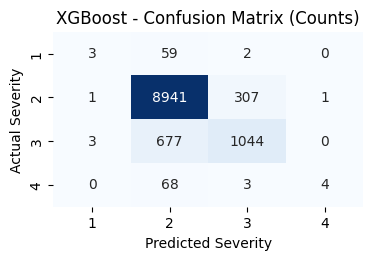

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',   # pour classification binaire
    eval_metric='logloss',
    random_state=42,
    reg_alpha	= 1,
    reg_lambda =	1.5,
    min_child_weight	= 1
)

# Train the model
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

plot_enhanced_confusion_matrix(y_test, y_pred_xgb, model_name="XGBoost")


Classification Report:
              precision    recall  f1-score   support

           1       0.16      0.20      0.18        64
           2       0.92      0.94      0.93      9250
           3       0.68      0.64      0.66      1724
           4       0.34      0.16      0.22        75

    accuracy                           0.88     11113
   macro avg       0.53      0.49      0.50     11113
weighted avg       0.88      0.88      0.88     11113


Class-wise Accuracy:
Severity 1: 20.31%
Severity 2: 93.81%
Severity 3: 63.92%
Severity 4: 16.00%


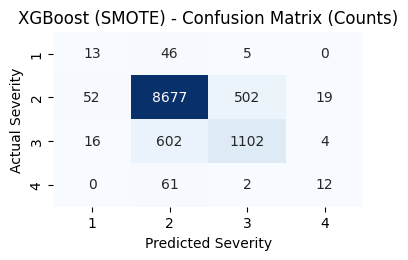

In [9]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Create XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',   # pour classification binaire
    eval_metric='logloss',
    random_state=42,
    reg_alpha	= 1,
    reg_lambda =	1.5,
    min_child_weight	= 1
)
# Train model
xgb.fit(X_train_bal, y_train_bal)

# Predict
y_pred_xgb = xgb.predict(X_test)

plot_enhanced_confusion_matrix(y_test, y_pred_xgb, model_name="XGBoost (SMOTE)")


Classification Report:
              precision    recall  f1-score   support

           1       0.16      0.20      0.18        64
           2       0.92      0.94      0.93      9250
           3       0.68      0.64      0.66      1724
           4       0.34      0.16      0.22        75

    accuracy                           0.88     11113
   macro avg       0.53      0.49      0.50     11113
weighted avg       0.88      0.88      0.88     11113


Class-wise Accuracy:
Severity 1: 20.31%
Severity 2: 93.81%
Severity 3: 63.92%
Severity 4: 16.00%


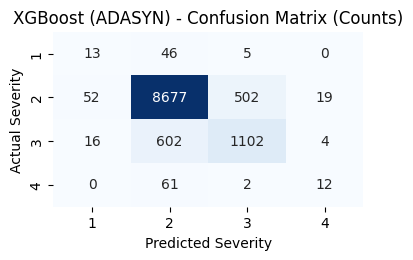

In [10]:
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Resample training data with ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
# Create XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',   # pour classification binaire
    eval_metric='logloss',
    random_state=42,
    reg_alpha	= 1,
    reg_lambda =	1.5,
    min_child_weight	= 1
)
# Train model
xgb.fit(X_train_bal, y_train_bal)

# Predict
y_pred_xgb = xgb.predict(X_test)

plot_enhanced_confusion_matrix(y_test, y_pred_xgb, model_name="XGBoost (ADASYN)")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 44451, number of used features: 27
[LightGBM] [Info] Start training from score -5.137622
[LightGBM] [Info] Start training from score -0.186447
[LightGBM] [Info] Start training from score -1.852342
[LightGBM] [Info] Start training from score -4.912183

Classification Report:
              precision    recall  f1-score   support

           1       0.43      0.05      0.08        64
           2       0.91      0.98      0.94      9250
           3       0.81      0.53      0.64      1724
           4       0.50      0.03      0.05        75

    accuracy                           0.90     11113
   macro avg       0.66      0.40      0.43     11113
weighted avg       0.89      0.90      0.88     11113


Class-wise Accuracy:
Severity 1: 4.

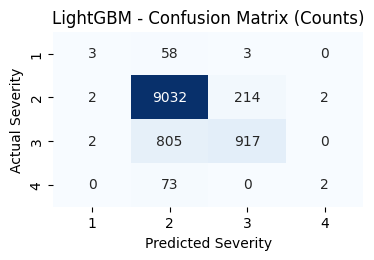

In [14]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create LightGBM model with good hyperparameters for multi-class classification
lgbm = lgb.LGBMClassifier(
    objective='multiclass',          # for multi-class classification
    num_class=4,                     # number of classes
    boosting_type='gbdt',            # Gradient Boosting Decision Tree (default)
    num_leaves=31,                   # number of leaves in the tree (default)
    max_depth=-1,                    # No limit for tree depth
    learning_rate=0.05,              # Step size for gradient descent (tune for better results)
    n_estimators=100,                # Number of boosting iterations (trees)
    subsample=0.9,                   # Fraction of samples used for each tree
    colsample_bytree=0.9,            # Fraction of features used for each tree
    random_state=42
)

# Train the model
lgbm.fit(X_train, y_train)

# Predict
y_pred_lgbm = lgbm.predict(X_test)

# Evaluate the model with confusion matrix and classification report
plot_enhanced_confusion_matrix(y_test, y_pred_lgbm, model_name="LightGBM")

# Additional metrics for evaluation
print(classification_report(y_test, y_pred_lgbm))


Clustering => classification

Résumé de mon idée :
Faire un clustering non supervisé (par ex. KMeans, DBSCAN, ou autre).

Observer si les clusters naturels retrouvés correspondent bien à 2 groupes principaux.

Si oui, alors :

Regrouper classe 1 et 2 → nouvelle classe Léger

Regrouper classe 3 et 4 → nouvelle classe Grave

In [3]:
df_Cluster = df.groupby('Severity', group_keys=False).apply(
    lambda x: x.sample(frac=0.1, random_state=42)  # 10% sample
)

<ipython-input-3-ff700aba65e7>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_Cluster = df.groupby('Severity', group_keys=False).apply(


In [4]:
def resume_clusters(df, cluster_col):
    results = []

    for cluster in sorted(df[cluster_col].unique()):
        group = df[df[cluster_col] == cluster]
        total = len(group)

        # Géolocalisation moyenne (approx.)
        avg_lat = group['Start_Lat'].mean()
        avg_lng = group['Start_Lng'].mean()

        # Heure de pic (mode)
        peak_hour = group['Hour'].mode()[0] if 'Hour' in group else None

        # Distribution de la gravité
        severity_dist = group['Severity'].value_counts(normalize=True).sort_index()



        # Top météo
        top_weather = group['Weather_Condition'].value_counts().idxmax() if 'Weather_Condition' in group else None

        # Construction de la ligne du tableau
        row = {
            'Cluster': cluster,
            'Nb_accidents': total,
            'Lat_moy': round(avg_lat, 2),
            'Lng_moy': round(avg_lng, 2),
            'Severity_1(%)': round(severity_dist.get(1, 0)*100, 1),
            'Severity_2(%)': round(severity_dist.get(2, 0)*100, 1),
            'Severity_3(%)': round(severity_dist.get(3, 0)*100, 1),
            'Severity_4(%)': round(severity_dist.get(4, 0)*100, 1),
            'Top météo': top_weather
        }

        results.append(row)

    return pd.DataFrame(results)

In [6]:
from sklearn.preprocessing import StandardScaler
features = [ 'Temperature(F)', 'Humidity(%)',
    'Wind_Speed(mph)', 'Precipitation(in)', 'Severity']
X = df_Cluster[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


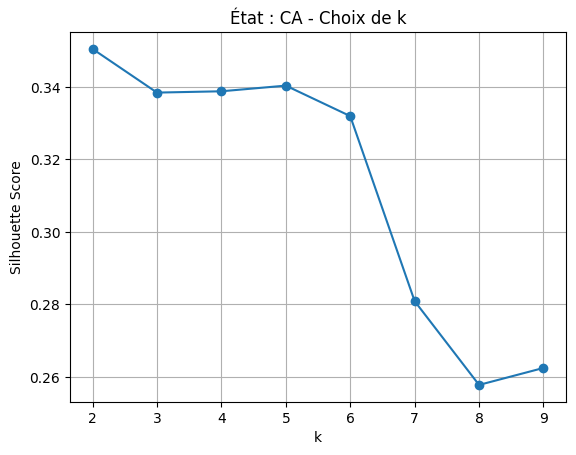

Meilleur k pour CA = 2


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
scores = []
k_range = range(2,10)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)

plt.plot(k_range, scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title(f"État : CA - Choix de k")
plt.grid(True)
plt.show()

best_k = k_range[np.argmax(scores)]
print(f"Meilleur k pour CA = {best_k}")

In [8]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
df_Cluster['Cluster'] = kmeans.fit_predict(X_scaled)
resume_clusters(df_Cluster, cluster_col='Cluster')

,Cluster,Nb_accidents,Lat_moy,Lng_moy,Severity_1(%),Severity_2(%),Severity_3(%),Severity_4(%),Top météo
0,0,23231,35.72,-119.56,0.7,99.3,0.0,0.0,None
1,1,4551,35.16,-119.18,0.0,0.0,95.6,4.4,None


In [ ]:
data=df.copy()

In [9]:
# Regroupement des classes
def fusion_severity(sev):
    if sev in [1, 2]:
        return 0  # Léger
    else:
        return 1  # Grave

df['Severity_Fused'] = df['Severity'].apply(fusion_severity)


In [10]:
df.drop('Severity', axis=1, inplace=True)

<ipython-input-11-faf2e25092de>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Severity', y='Accidents', data=df_severity, palette='Reds')


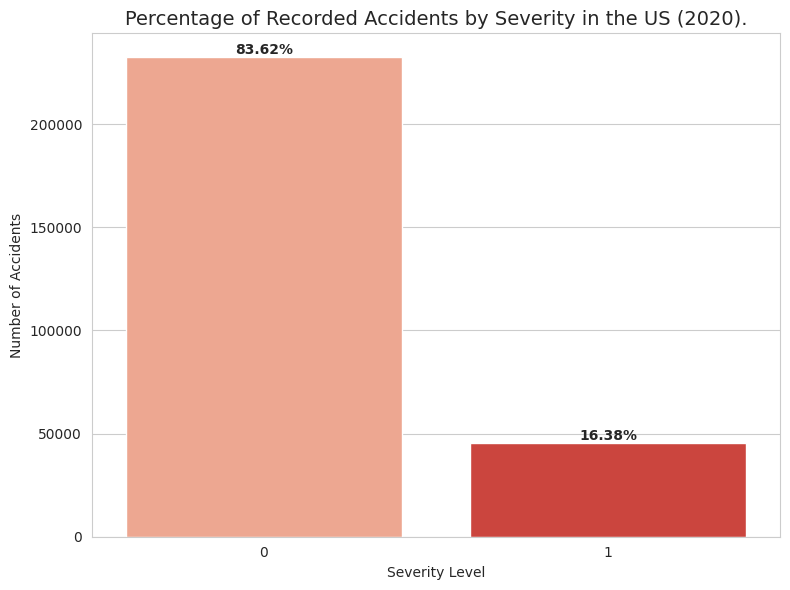

In [11]:
# Compter les accidents par gravité
accidents_by_severity = df['Severity_Fused'].value_counts().sort_index()

# Calculer les pourcentages
total_accidents = len(df)
severity_percentages = (accidents_by_severity / total_accidents) * 100

# Créer un DataFrame pour l'affichage
df_severity = pd.DataFrame({
    'Severity': accidents_by_severity.index.astype(str),
    'Accidents': accidents_by_severity.values,
    'Percentage': severity_percentages.values
})

# Tracer le graphique
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
barplot = sns.barplot(x='Severity', y='Accidents', data=df_severity, palette='Reds')

# Ajouter les pourcentages au-dessus des barres
for i, row in df_severity.iterrows():
    barplot.text(i, row['Accidents'], f"{row['Percentage']:.2f}%", ha='center', va='bottom', fontsize=10, weight='bold')

plt.title('Percentage of Recorded Accidents by Severity in the US (2020).', fontsize=14)
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

In [12]:
# Stratified sampling to maintain severity distribution
df_sample = df.groupby('Severity_Fused', group_keys=False).apply(
    lambda x: x.sample(frac=0.2, random_state=42) )

<ipython-input-12-fb2477140c40>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('Severity_Fused', group_keys=False).apply(


In [13]:
# Features and target
X = df_sample.drop('Severity_Fused', axis=1)
y = df_sample['Severity_Fused'] - 1

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_enhanced_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Plot an enhanced confusion matrix with normalized view and performance metrics

    Args:
        y_true (array): True labels
        y_pred (array): Predicted labels
        model_name (str): Name of model for title
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ['1', '2']

    # Create figure
    plt.figure(figsize=(4, 5))

    # Plot absolute values
    plt.subplot(2, 1, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels,
                cbar=False)
    plt.title(f"{model_name} - Confusion Matrix (Counts)")
    plt.xlabel("Predicted Severity")
    plt.ylabel("Actual Severity")


    # Print classification metrics
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

    # Calculate class-wise accuracy
    class_acc = cm.diagonal()/cm.sum(axis=1)
    print("\nClass-wise Accuracy:")
    for i, acc in enumerate(class_acc):
        print(f"Severity {i+1}: {acc:.2%}")


# K-Nearest Neighbors (KNN)



Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.92      0.90     13940
           2       0.46      0.34      0.39      2730

    accuracy                           0.83     16670
   macro avg       0.67      0.63      0.64     16670
weighted avg       0.81      0.83      0.82     16670


Class-wise Accuracy:
Severity 1: 92.17%
Severity 2: 33.88%


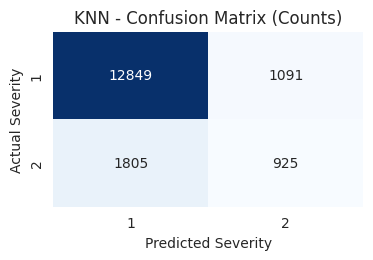

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# KNN model (try different values of k: 3, 5, 7, etc.)
model_knn = KNeighborsClassifier(n_neighbors=5,
    weights='distance',
    metric='minkowski',
    p=2,                # Distance euclidienne
    algorithm='auto',
    leaf_size=30)
model_knn.fit(X_train, y_train)

# Predictions
y_pred_knn = model_knn.predict(X_test)

plot_enhanced_confusion_matrix(y_test, y_pred_knn, model_name="KNN")

# Random forest


Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.98      0.95     13940
           2       0.83      0.58      0.68      2730

    accuracy                           0.91     16670
   macro avg       0.87      0.78      0.82     16670
weighted avg       0.91      0.91      0.90     16670


Class-wise Accuracy:
Severity 1: 97.62%
Severity 2: 58.10%


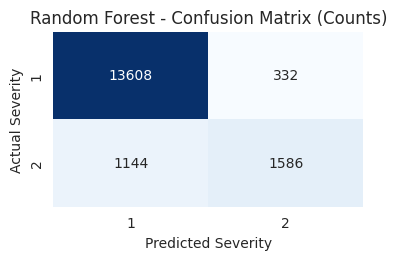

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


# Model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    min_samples_split=6,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)

rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

plot_enhanced_confusion_matrix(y_test, y_pred_rf, model_name="Random Forest")


Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.95      0.94     13940
           2       0.70      0.61      0.66      2730

    accuracy                           0.89     16670
   macro avg       0.81      0.78      0.80     16670
weighted avg       0.89      0.89      0.89     16670


Class-wise Accuracy:
Severity 1: 94.91%
Severity 2: 61.43%


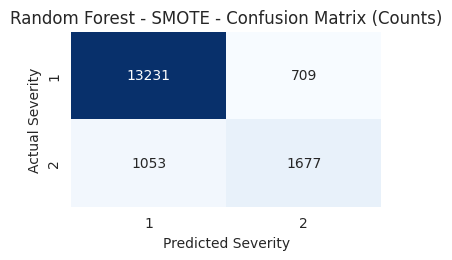

In [17]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train RandomForest with class weights
rf = RandomForestClassifier( n_estimators=100,
    max_depth=50,
    min_samples_split=6,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False,
    random_state=42)
rf.fit(X_resampled, y_resampled)

# Predict on original test set
y_pred_rf = rf.predict(X_test)

plot_enhanced_confusion_matrix(y_test, y_pred_rf, model_name="Random Forest - SMOTE")

# xgboost

In [ ]:
# Features and target
X = df_sample.drop('Severity_Fused', axis=1)
y = df_sample['Severity_Fused']



Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.96      0.95      9314
           2       0.77      0.62      0.69      1799

    accuracy                           0.91     11113
   macro avg       0.85      0.79      0.82     11113
weighted avg       0.90      0.91      0.90     11113


Class-wise Accuracy:
Severity 1: 96.41%
Severity 2: 61.87%


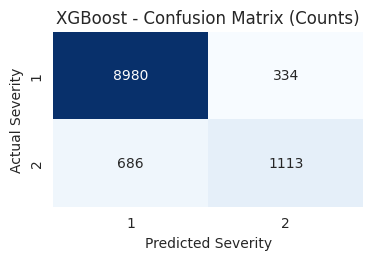

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',   # pour classification binaire
    eval_metric='logloss',
    random_state=42,
    reg_alpha	= 1,
    reg_lambda =	1.5,
    min_child_weight	= 1
)

# Train the model
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

plot_enhanced_confusion_matrix(y_test, y_pred_xgb, model_name="XGBoost")

In [ ]:
!pip install optuna

In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 2),
        'random_state': 42
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted')
    return score.mean()


In [ ]:
study = optuna.create_study(direction='maximize')  # maximise f1_weighted
study.optimize(objective, n_trials=30, timeout=300)  # 30 essais ou 5 minutes

[I 2025-04-25 23:27:55,906] A new study created in memory with name: no-name-77406b6f-e34c-4cd5-a434-c9554f1ab352
[I 2025-04-25 23:28:00,141] Trial 0 finished with value: 0.895282162178254 and parameters: {'n_estimators': 206, 'learning_rate': 0.2947553915581263, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.908861147909505, 'colsample_bytree': 0.9075569417583792, 'gamma': 0.17455828340639223, 'reg_alpha': 0.8290493064842529, 'reg_lambda': 1.3561705035638352}. Best is trial 0 with value: 0.895282162178254.
[I 2025-04-25 23:28:06,197] Trial 1 finished with value: 0.8942062039513479 and parameters: {'n_estimators': 238, 'learning_rate': 0.27778715745620935, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.820220043197315, 'colsample_bytree': 0.8309516852475165, 'gamma': 0.22783414071412028, 'reg_alpha': 0.9320155323156114, 'reg_lambda': 1.2450381920611662}. Best is trial 0 with value: 0.895282162178254.
[I 2025-04-25 23:28:09,192] Trial 2 finished with value: 0.8932476098103

In [ ]:
best_params = study.best_params
print("Best params:", best_params)

best_model = XGBClassifier(**best_params, use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')
best_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:31:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params: {'n_estimators': 300, 'learning_rate': 0.05328438816497785, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.7836960530395598, 'colsample_bytree': 0.6771292754293392, 'gamma': 0.41393251045389584, 'reg_alpha': 0.7834892840637848, 'reg_lambda': 1.4742571000990752}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6771292754293392, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.41393251045389584, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05328438816497785,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      9314
           1       0.79      0.61      0.69      1799

    accuracy                           0.91     11113
   macro avg       0.86      0.79      0.82     11113
weighted avg       0.91      0.91      0.91     11113


Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.97      0.95      9314
           2       0.79      0.61      0.69      1799

    accuracy                           0.91     11113
   macro avg       0.86      0.79      0.82     11113
weighted avg       0.91      0.91      0.91     11113


Class-wise Accuracy:
Severity 1: 96.88%
Severity 2: 60.76%


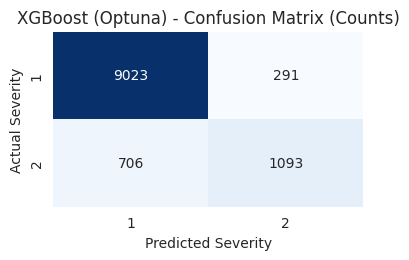

In [ ]:
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
plot_enhanced_confusion_matrix(y_test, y_pred, model_name="XGBoost (Optuna)")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 6369, number of negative: 32525
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 38894, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163753 -> initscore=-1.630567
[LightGBM] [Info] Start training from score -1.630567

Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.97      0.95     13940
           2       0.80      0.60      0.69      2730

    accuracy                           0.91     16670
   macro avg       0.86      0.79      0.82     16670
weighted avg       0.91      0.91      0.91     16670


Class-wise Accuracy:
Severity 1: 97.09%
Severity 2: 60.40%


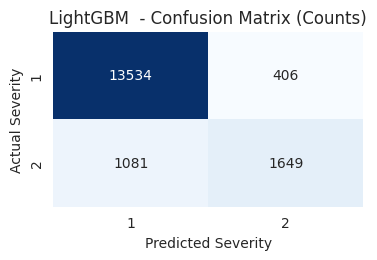

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Modèle
lgbm = LGBMClassifier(objective='binary', random_state=42)

# Grille d'hyperparamètres
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, -1],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 1, 2]
}

# Recherche
search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
best_lgbm = search.best_estimator_

# Évaluation
y_pred = best_lgbm.predict(X_test)
plot_enhanced_confusion_matrix(y_test, y_pred, model_name="LightGBM ")



Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.65      0.77     13940
           2       0.31      0.80      0.45      2730

    accuracy                           0.68     16670
   macro avg       0.63      0.73      0.61     16670
weighted avg       0.84      0.68      0.72     16670


Class-wise Accuracy:
Severity 1: 65.08%
Severity 2: 80.04%


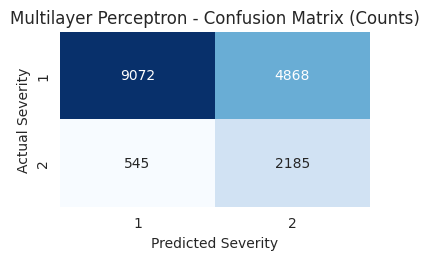

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_enhanced_confusion_matrix(y_test, y_pred, model_name="Multilayer Perceptron")


In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prétraitement des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Création du modèle avec Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='tanh', input_shape=(X_train_scaled.shape[1],)),  # Couche d'entrée
    tf.keras.layers.Dense(64, activation='tanh'),  # Couche cachée
    tf.keras.layers.Dense(32, activation='tanh'),  # Couche cachée
    tf.keras.layers.Dense(16, activation='tanh'),  # Couche cachée
    tf.keras.layers.Dense(1, activation='sigmoid')  # Couche de sortie (pour binaire)
])

# Compilation du modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Évaluation sur le jeu de test
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


973/973 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8139 - loss: 0.4073 - val_accuracy: 0.8450 - val_loss: 0.3514
Epoch 2/20
973/973 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8433 - loss: 0.3492 - val_accuracy: 0.8461 - val_loss: 0.3485
Epoch 3/20
973/973 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8488 - loss: 0.3420 - val_accuracy: 0.8536 - val_loss: 0.3384
Epoch 4/20
973/973 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8540 - loss: 0.3319 - val_accuracy: 0.8541 - val_loss: 0.3369
Epoch 5/20
973/973 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8531 - loss: 0.3283 - val_accuracy: 0.8513 - val_loss: 0.3404
Epoch 6/20
973/973 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8550 - loss: 0.3282 - val_accuracy: 0.8506 - val_loss: 0.3386
Epoch 7/20
973/973 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8554 - loss: 0.3267 - val_accuracy: 0.8483 - val_loss: 0.3337
Epoch 8/20
973/973 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8550 - loss: 0.3243 - val_accuracy: 0.8562 - val

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

# Prétraitement des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Création du modèle avec Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Augmenter la taille de la couche
    tf.keras.layers.BatchNormalization(),  # Normalisation des batchs
    tf.keras.layers.Dropout(0.3),  # Dropout modéré pour éviter le surapprentissage
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Couche de sortie (pour binaire)
])

# Compilation du modèle avec un optimiseur Adam et learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Learning rate de base
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping pour éviter le surapprentissage
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement du modèle
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Évaluation sur le jeu de test
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


973/973 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.7707 - loss: 1.0292 - val_accuracy: 0.8398 - val_loss: 0.6322
Epoch 2/50
973/973 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8382 - loss: 0.5915 - val_accuracy: 0.8438 - val_loss: 0.4643
Epoch 3/50
973/973 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8372 - loss: 0.4622 - val_accuracy: 0.8506 - val_loss: 0.4121
Epoch 4/50
973/973 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8368 - loss: 0.4202 - val_accuracy: 0.8481 - val_loss: 0.3937
Epoch 5/50
973/973 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8396 - loss: 0.3991 - val_accuracy: 0.8555 - val_loss: 0.3943
Epoch 6/50
973/973 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8423 - loss: 0.3979 - val_accuracy: 0.8470 - val_loss: 0.3918
Epoch 7/50
973/973 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8416 - loss: 0.3932 - val_accuracy: 0.8529 - val_loss: 0.3856
Epoch 8/50
973/973 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8382 - loss: 0.3946 - val_accuracy: 0.8565 

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor="val_loss", mode="min"
)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler, checkpoint_cb],
    verbose=1
)
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


487/487 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8217 - loss: 0.9329 - val_accuracy: 0.8337 - val_loss: 0.7155 - learning_rate: 0.0010
Epoch 2/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8365 - loss: 0.6758 - val_accuracy: 0.8505 - val_loss: 0.5443 - learning_rate: 0.0010
Epoch 3/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8357 - loss: 0.5289 - val_accuracy: 0.8555 - val_loss: 0.4537 - learning_rate: 0.0010
Epoch 4/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8378 - loss: 0.4568 - val_accuracy: 0.8432 - val_loss: 0.4234 - learning_rate: 0.0010
Epoch 5/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8413 - loss: 0.4202 - val_accuracy: 0.8533 - val_loss: 0.3927 - learning_rate: 0.0010
Epoch 6/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8434 - loss: 0.3999 - val_accuracy: 0.8544 - val_loss: 0.3853 - learning_rate: 0.0010
Epoch 7/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8466 - loss: 0.3869 - val